# Testing GOAT
Pranav Mathur

In [1]:
import numpy as np
from numpy.polynomial import chebyshev
import matplotlib.pyplot as plt
from goat_optimization import run_goat_optimization
from qutip_gate_simulation import data_from_tstep, simulate_gate, calculate_fidelity
from scipy.optimize import NonlinearConstraint

## Rydberg Gates

In [2]:
# define hamiltonians
H0 = np.zeros((4, 4))

H_plus = np.array([[0, 0, 1/2, 0],
                   [0, 0, 0, np.sqrt(2)/2],
                   [0, 0, 0, 0],
                   [0, 0, 0, 0]])
H_minus = np.array([[0, 0, 0, 0],
                    [0, 0, 0, 0],
                    [1/2, 0, 0, 0],
                    [0, np.sqrt(2)/2, 0, 0]])
H_controls = [H_plus, H_minus]

U_target = np.array([[1, 0],
                     [0, -1]])

In [3]:
# define control functions
def to_control_func_plus(t, alpha, control_extra_params=None):
    """control_extra_params should be {"Omega_max", "t_max", "n_pieces"}"""
    dt = control_extra_params["t_max"] / control_extra_params["n_pieces"]
    j = int(t / dt)
    return control_extra_params["Omega_max"] * np.exp(1j * alpha[j])

def to_control_func_minus(t, alpha, control_extra_params=None):
    """control_extra_params should be {"Omega_max", "t_max", "n_pieces"}"""
    dt = control_extra_params["t_max"] / control_extra_params["n_pieces"]
    j = int(t / dt)
    return control_extra_params["Omega_max"] * np.exp(-1j * alpha[j])

def to_control_param_derivs(t, alpha, control_extra_params=None):
    """control_extra_params should be {"Omega_max", "t_max", "n_pieces"}"""
    dt = control_extra_params["t_max"] / control_extra_params["n_pieces"]
    j = int(t / dt)
    deriv_matrix = np.zeros((2, alpha.size), dtype=complex)
    deriv_matrix[0][j] = 1j * control_extra_params["Omega_max"] * np.exp(1j * alpha[j])
    deriv_matrix[1][j] = -1j * control_extra_params["Omega_max"] * np.exp(-1j * alpha[j])
    return deriv_matrix

def chebyshev_control_func_plus(t, alpha, control_extra_params=None):
    return control_extra_params["Omega_max"] * np.exp( 1j * chebyshev.chebval( (2/control_extra_params["t_max"])*t-1, alpha) )

def chebyshev_control_func_minus(t, alpha, control_extra_params=None):
    return control_extra_params["Omega_max"] * np.exp( -1j * chebyshev.chebval( (2/control_extra_params["t_max"])*t-1, alpha) )

def chebyshev_control_param_derivs(t, alpha, control_extra_params=None):
    deriv_matrix = np.zeros((2, alpha.size), dtype=complex)
    phase = chebyshev.chebval((2/control_extra_params["t_max"])*t-1, alpha)
    plus_exp_val = 1j * control_extra_params["Omega_max"] * np.exp(1j * phase)
    minus_exp_val = -1j * control_extra_params["Omega_max"] * np.exp(-1j * phase)
    for i in range(alpha.size):
        c = np.zeros(alpha.size)
        c[i] = 1
        deriv_matrix[0][i] = plus_exp_val * chebyshev.chebval((2/control_extra_params["t_max"])*t-1, c)
        deriv_matrix[1][i] = minus_exp_val * chebyshev.chebval((2/control_extra_params["t_max"])*t-1, c)
    return deriv_matrix

# control_funcs = [to_control_func_plus, to_control_func_minus]
# control_param_derivs = to_control_param_derivs
control_funcs = [chebyshev_control_func_plus, chebyshev_control_func_minus]
control_param_derivs = chebyshev_control_param_derivs

def U_truncator(U_full):
    if U_full.ndim == 2:
        return U_full[0:2, 0:2]
    else:
        return U_full[:, 0:2, 0:2]

In [4]:
# initial values of piecewise controls
def load_pulse_profile_from_csv(filename):
    gate_parameters = np.genfromtxt(filename, delimiter=',', skip_header=1, filling_values=np.nan)
    t_min = gate_parameters[0, 0]
    t_max = gate_parameters[-2, 0]
    t_steps = gate_parameters[:-1, 0]
    drive_strengths = gate_parameters[:-1, 1]
    phases = gate_parameters[:-1, 2]

    return t_min, t_max, t_steps, drive_strengths, phases

t_min, t_max, t_steps, drive_strengths, phases = load_pulse_profile_from_csv("./pulses/01_cz.csv")
t_span = [t_min, t_max]
n_pieces = phases.size
alpha0 = np.concatenate((phases, [0]))

# custom initial values

# t_max = 7.612 # from TO gates paper
# n_pieces = 100
# t_span = [0, t_max]

# # alpha0 = np.random.uniform(low=np.pi/2, high=(3/2)*np.pi, size=n_pieces+1)
# alpha0 = 0.3 * np.ones(n_pieces + 1) 
# # alpha0 = np.zeros(n_pieces + 1)
# # alpha0 = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=n_pieces+1)

# alpha_bounds = np.tile([0, 2*np.pi], (n_pieces + 1, 1)) 
alpha_bounds = np.tile([-np.pi, np.pi], (n_pieces + 1, 1)) 

In [4]:
# initial values of chebyshev controls
t_min = 0
t_max = 7.612 # from TO gates paper TODO: try lower gate time
t_span = [t_min, t_max]

n_cheb_polys = 10
alpha0 = np.zeros(n_cheb_polys + 1)
alpha0[3] = 1

In [5]:
# control extra parameters and callback functions
control_extra_params = {
    "Omega_max": 1,
    "t_max": t_max,
    # "n_pieces": n_pieces
}

# approximate maximum of chebyshev series
def chebyshev_max(coeffs):
    N = coeffs.size - 1
    K = 4 * N
    x = np.cos(np.pi * np.arange(K+1) / K) # chebyshev points
    f = chebyshev.chebval(x, coeffs[:-1])
    return np.max(np.abs(f))    

def chebyshev_max_grad(coeffs):
    N = coeffs.size - 1
    K = 4 * N
    x = np.cos(np.pi * np.arange(K+1) / K) # chebyshev points
    f = chebyshev.chebval(x, coeffs[:-1])
    max_i = np.argmax(np.abs(f))
    max_x = x[max_i]
    sgn = np.sign(f[max_i])
    grad = np.zeros(N+1)
    for i in range(N):
        c = np.zeros(N)
        c[i] = 1
        grad[i] = chebyshev.chebval(max_x, c)
    return sgn * grad

chebyshev_constraint = NonlinearConstraint(chebyshev_max, 
                                           lb=0, 
                                           ub=np.pi)
                                        #    jac=chebyshev_max_grad)

prev_params = []
def callback(x, state=None):
    prev_params.append(np.copy(x))

In [6]:
# import cProfile
# import pstats

# profiler = cProfile.Profile()
# profiler.enable()

res = run_goat_optimization(
    H0,
    H_controls,
    control_funcs,
    control_param_derivs,
    alpha0,
    U_target,
    t_span,
    U_truncator,
    fidelity_func_name="TO",
    # alpha_bounds=alpha_bounds,
    constraints=chebyshev_constraint,
    single_qubit_phase_weights=[1, 2],
    control_extra_params=control_extra_params,
    callback=callback
)

# profiler.disable()
# stats = pstats.Stats(profiler)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |   1   |   0   | +6.9280e-01 | 1.00e+00 | 2.61e-01 | 0.00e+00 | 1.00e+00 |  1.00e-03   |   0   |
|   2   |   2   |   1   | +6.2315e-01 | 3.38e+00 | 3.50e-01 | 0.00e+00 | 1.00e+00 |  1.00e-03   |   4   |
|   3   |   3   |   2   | +5.1850e-01 | 3.38e+00 | 4.30e-01 | 0.00e+00 | 1.00e+00 |  1.00e-03   |   4   |
|   4   |   4   |   3   | +3.8641e-01 | 3.38e+00 | 4.65e-01 | 0.00e+00 | 1.00e+00 |  1.00e-03   |   4   |
|   5   |   5   |   5   | +2.5539e-01 | 3.38e+00 | 4.19e-01 | 0.00e+00 | 1.00e+00 |  1.00e-03   |   4   |
|   6   |   7   |   7   | +2.5539e-01 | 8.88e-01 | 4.19e-01 | 0.00e+00 | 1.00e+00 |  1.00e-03   |   4   |
|   7   |   9   |   9   | +1.3724e-01 | 1.78e+00 | 2.64e-01 | 0.00e+00 | 1.00e+00 |  1.00e-03   |   2   |


/opt/miniconda3/envs/miscenv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


|   8   |  11   |  13   | +1.3724e-01 | 1.78e-01 | 2.64e-01 | 0.00e+00 | 1.00e+00 |  1.00e-03   |   4   |
|   9   |  12   |  15   | +8.6853e-02 | 3.55e-01 | 1.56e-01 | 0.00e+00 | 1.00e+00 |  1.00e-03   |   2   |
|  10   |  14   |  19   | +8.6853e-02 | 4.69e-02 | 1.56e-01 | 0.00e+00 | 1.00e+00 |  1.00e-03   |   4   |
|  11   |  15   |  20   | +7.5939e-02 | 3.28e-01 | 1.26e-01 | 0.00e+00 | 1.00e+00 |  1.00e-03   |   2   |
|  12   |  17   |  25   | +7.5939e-02 | 3.28e-02 | 1.26e-01 | 0.00e+00 | 1.00e+00 |  1.00e-03   |   2   |
|  13   |  18   |  26   | +6.9912e-02 | 2.30e-01 | 1.16e-01 | 0.00e+00 | 1.00e+00 |  1.00e-03   |   2   |
|  14   |  20   |  28   | +4.1138e-02 | 2.30e-01 | 9.22e-02 | 0.00e+00 | 1.00e+00 |  1.00e-03   |   2   |
|  15   |  21   |  31   | +2.1078e-02 | 1.61e+00 | 9.80e-02 | 0.00e+00 | 1.00e+00 |  1.00e-03   |   2   |
|  16   |  22   |  36   | +9.4551e-03 | 1.99e+00 | 1.50e-01 | 0.00e+00 | 1.00e+00 |  1.00e-03   |   4   |
|  17   |  23   |  38   | +5.2423e-03 | 1.99e+

In [9]:
res

           message: `xtol` termination condition is satisfied.
           success: True
            status: 2
               fun: 3.0619721748115225e-06
                 x: [ 7.677e-02  7.835e-02  3.181e-02  5.741e-01  3.407e-02
                     -1.941e-01  3.862e-02  9.556e-02  2.670e-02  1.499e-02
                     -2.154e+00]
               nit: 129
              nfev: 190
              njev: 190
              nhev: 0
          cg_niter: 479
      cg_stop_cond: 2
              grad: [ 1.416e-16  5.820e-05  4.681e-05  2.836e-05  1.852e-05
                      4.325e-05  1.049e-05  4.018e-05  4.342e-05 -2.359e-05
                      2.883e-05]
   lagrangian_grad: [-2.131e-05  3.689e-05  2.550e-05  7.041e-06 -2.791e-06
                      5.120e-05 -1.082e-05  1.887e-05  2.211e-05 -4.490e-05
                      2.883e-05]
            constr: [array([ 7.769e-01])]
               jac: [array([[ 1.000e+00,  1.000e+00,  1.000e+00,
                             1.000e+00,  1.00

In [19]:
# load previous run data
import pickle

with open("results/goat_run_12.pkl", "rb") as file:
    (res, prev_params) = pickle.load(file)

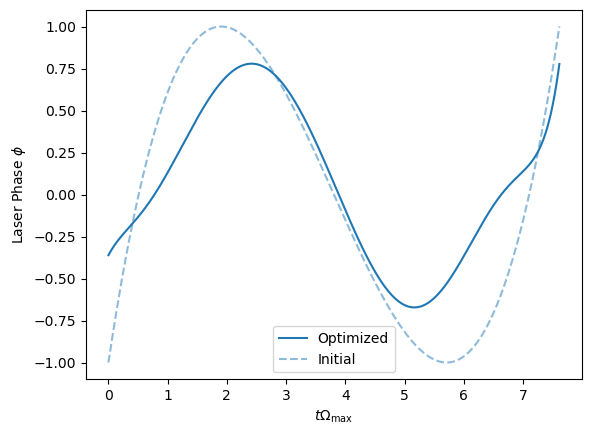

In [7]:
# plot piecewise-continouous gate
# plt.step(np.linspace(0, t_max, n_pieces), res.x[:-1], color="tab:blue", label="Optimized")
# plt.step(np.linspace(0, t_max, n_pieces), alpha0[:-1], alpha=0.35, label="Initial")
# plt.xlabel("$t\\Omega_{\\text{max}}$")
# plt.ylabel("Laser Phase $\\phi$")
# plt.legend()

# plot chebyshev gate
ts = np.linspace(0, t_max, 10001)
plt.xlabel("$t\\Omega_{\\text{max}}$")
plt.ylabel("Laser Phase $\\phi$")
plt.plot(ts, chebyshev.chebval((2/control_extra_params["t_max"])*ts-1, res.x[:-1]), color="tab:blue", label="Optimized")
plt.plot(ts, chebyshev.chebval((2/control_extra_params["t_max"])*ts-1, alpha0), linestyle="--", alpha=0.5, label="Initial")
plt.legend()

plt.show()

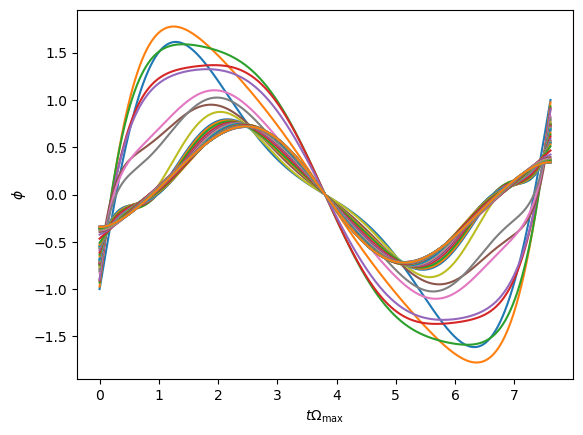

In [10]:
# plot how gate changed during optimization
for i in range(len(prev_params)):
    # plt.step(np.linspace(0, t_max, n_pieces), prev_params[i][:-1], alpha=0.3, label=f"{i}")

    ts = np.linspace(0, t_max, 10001)
    plt.plot(ts, chebyshev.chebval((2/control_extra_params["t_max"])*ts-1, prev_params[i][:-1]))
# plt.step(np.linspace(0, t_max, 100), prev_params[-2][:-1], alpha=0.3) # , label=f"{i}")
plt.xlabel("$t\\Omega_{\\text{max}}$")
plt.ylabel("$\\phi$")
# plt.legend()
plt.show()

/opt/miniconda3/envs/miscenv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/miniconda3/envs/miscenv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


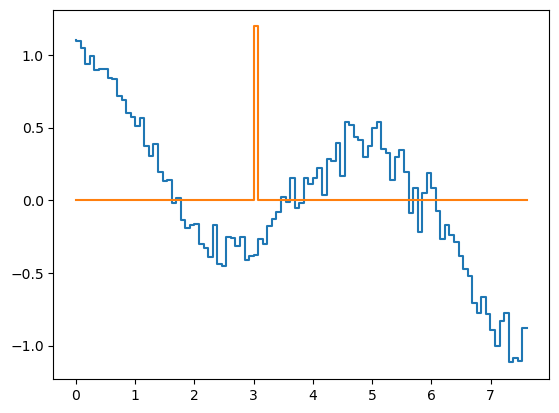

In [6]:
# check that piecewise controls are working
nts = 100
ts = np.linspace(0, t_max, nts)
controls = np.zeros(nts)
control_derivs = np.zeros(nts, dtype=complex)
deriv_j = 40
for i in range(nts):
    cval = to_control_func_plus(ts[i], res.x[:-1], control_extra_params)
    # print(cval)
    controls[i] = np.angle(cval)

    c_derivs = control_param_derivs(ts[i], res.x[:-1], control_extra_params)
    # print(c_derivs)
    control_derivs[i] = np.angle(c_derivs[0][deriv_j])

plt.step(ts, controls)
plt.step(ts, control_derivs)
plt.show()

/opt/miniconda3/envs/miscenv/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/opt/miniconda3/envs/miscenv/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


F = 0.9999377474631637


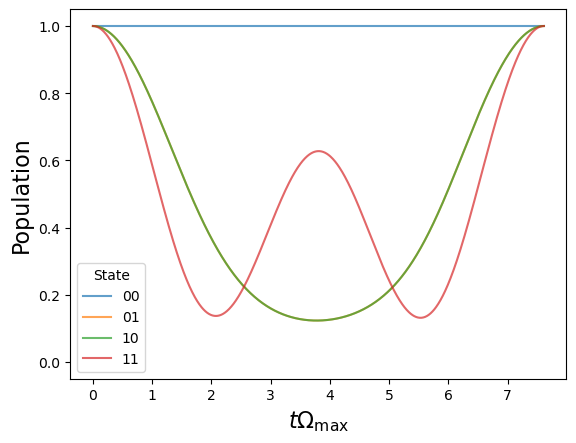

In [8]:
# simulate resulting gate in qutip
to_drive_strength_func = lambda t: 1
to_phase_func = lambda t: data_from_tstep(t, t_steps, res.x[:-1])

chebyshev_drive_strength_func = lambda t: 1
chebyshev_phase_func = lambda t: chebyshev.chebval((2/t_max)*t-1, res.x[:-1])

results = simulate_gate(chebyshev_drive_strength_func, chebyshev_phase_func, 100, 0, t_min, t_max, 1001)
# results = simulate_gate(to_drive_strength_func, to_phase_func, 100, 0, t_min, t_max, 1001)
print(f"F = {calculate_fidelity(results, single_qubit_phase=res.x[-1])}")
plt.show()

-2.1618843755377717
-2.172097160691983
0.9999771906711772


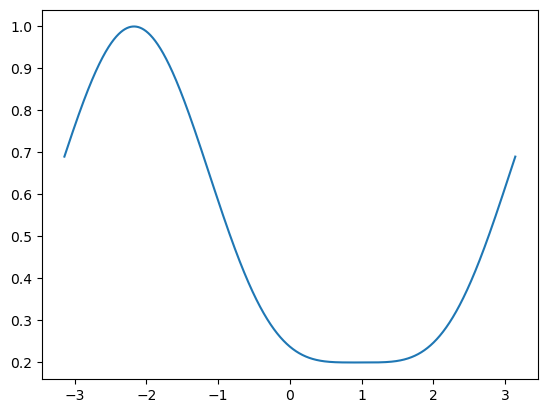

In [10]:
N = 10001
phases = np.linspace(-np.pi, np.pi, N)
fidelities = np.zeros(N)

for i in range(N):
    fidelities[i] = calculate_fidelity(results, single_qubit_phase=phases[i])
print(res.x[-1])
print(phases[np.argmax(fidelities)])
print(np.max(fidelities))

plt.plot(phases, fidelities)
plt.show()

## Sweep Gate Time

In [6]:
n_times = 14*5+1
gate_times = np.linspace(1, 15, n_times)
goat_results = []
fidelities = np.zeros(n_times)

control_funcs = [chebyshev_control_func_plus, chebyshev_control_func_minus]
control_param_derivs = chebyshev_control_param_derivs

n_cheb_polys = 10
alpha0 = np.zeros(n_cheb_polys + 1)
alpha0[3] = 1

for i in range(n_times):
    print(f"Gate time: {gate_times[i]}")
    t_min = 0
    t_max = gate_times[i] # from TO gates paper 
    t_span = [t_min, t_max]

    control_extra_params = {
        "Omega_max": 1,
        "t_max": gate_times[i],
        # "n_pieces": n_pieces
    }

    res = run_goat_optimization(
        H0,
        H_controls,
        control_funcs,
        control_param_derivs,
        alpha0,
        U_target,
        t_span,
        U_truncator,
        fidelity_func_name="GOAT",
        # alpha_bounds=alpha_bounds,
        constraints=chebyshev_constraint,
        single_qubit_phase_weights=[1, 2],
        control_extra_params=control_extra_params,
        callback=callback
    )

    goat_results.append(res)
    fidelities[i] = res.fun

Gate time: 1.0
| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |   1   |   0   | +9.6136e-01 | 1.00e+00 | 2.16e-01 | 0.00e+00 | 1.00e+00 |  1.00e-03   |   0   |
|   2   |   2   |   1   | +9.2324e-01 | 3.24e+00 | 3.96e-01 | 0.00e+00 | 1.00e+00 |  1.00e-03   |   4   |


/opt/miniconda3/envs/miscenv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


|   3   |   3   |   2   | +8.6198e-01 | 3.24e+00 | 4.26e-01 | 0.00e+00 | 1.00e+00 |  1.00e-03   |   4   |
|   4   |   4   |   3   | +7.9419e-01 | 3.24e+00 | 4.28e-01 | 0.00e+00 | 1.00e+00 |  1.00e-03   |   4   |
|   5   |   5   |   4   | +7.2634e-01 | 3.24e+00 | 4.22e-01 | 0.00e+00 | 1.00e+00 |  1.00e-03   |   4   |
|   6   |   6   |   5   | +1.2215e-01 | 3.24e+00 | 1.60e-01 | 0.00e+00 | 1.00e+00 |  1.00e-03   |   2   |
|   7   |   7   |   8   | +6.4985e-02 | 5.42e+00 | 8.83e-02 | 0.00e+00 | 1.00e+00 |  1.00e-03   |   4   |
|   8   |   8   |   9   | +5.6846e-02 | 5.42e+00 | 8.54e-02 | 0.00e+00 | 1.00e+00 |  1.00e-03   |   4   |
|   9   |  10   |  12   | +5.6846e-02 | 5.42e-01 | 8.54e-02 | 0.00e+00 | 1.00e+00 |  1.00e-03   |   4   |
|  10   |  12   |  13   | +5.6846e-02 | 5.42e-02 | 8.54e-02 | 0.00e+00 | 1.00e+00 |  1.00e-03   |   2   |
|  11   |  13   |  14   | +5.0842e-02 | 3.80e-01 | 8.25e-02 | 0.00e+00 | 1.00e+00 |  1.00e-03   |   2   |
|  12   |  15   |  15   | +5.0842e-02 | 3.80e-

In [7]:
for result in goat_results:
    print(f"1-F: {result.fun}, nit: {result.nit}")

1-F: 0.04881057003144851, nit: 150
1-F: 1.2885652375116408e-06, nit: 142
1-F: 0.04141574827407979, nit: 1000
1-F: 0.14493026016954658, nit: 1000
1-F: 0.024620165933899485, nit: 1000
1-F: 0.19799364938787822, nit: 1000
1-F: 0.1720916243354894, nit: 1000
1-F: 0.3521358884402954, nit: 1000
1-F: 0.3281334841332134, nit: 1000
1-F: 0.3560303127843768, nit: 1000
1-F: 0.3268496018303503, nit: 1000
1-F: 0.29124207416872316, nit: 1000
1-F: 0.2159455010435134, nit: 1000
1-F: 0.280516184371438, nit: 1000
1-F: 0.12372909626710427, nit: 441
1-F: 0.12123701517772767, nit: 1000
1-F: 0.22389198089595552, nit: 397
1-F: 0.24206700152369376, nit: 1000
1-F: 0.23999619713325915, nit: 1000
1-F: 0.40795792584293344, nit: 1000
1-F: 0.04739171799570785, nit: 1000
1-F: 0.016785198631064313, nit: 1000
1-F: 0.07265092292985531, nit: 1000
1-F: 0.06720002822050675, nit: 138
1-F: 0.06239827994643232, nit: 267
1-F: 5.022158244827324e-10, nit: 666
1-F: 0.030409226076590246, nit: 1000
1-F: 0.021923651234891706, nit: 100

In [27]:
# load results
import pickle

with open("results/time_sweep_1.pkl", "rb") as file:
    gate_times, goat_results, fidelities = pickle.load(file)

Text(0, 0.5, 'Infidelity')

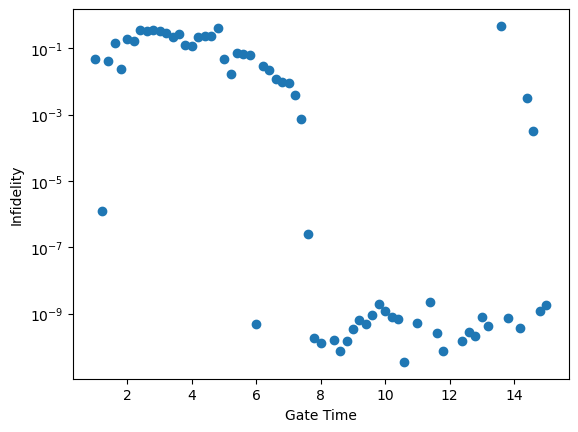

In [8]:
plt.semilogy(gate_times, fidelities, linestyle="", marker="o")
plt.xlabel("Gate Time")
plt.ylabel("Infidelity")

5.0


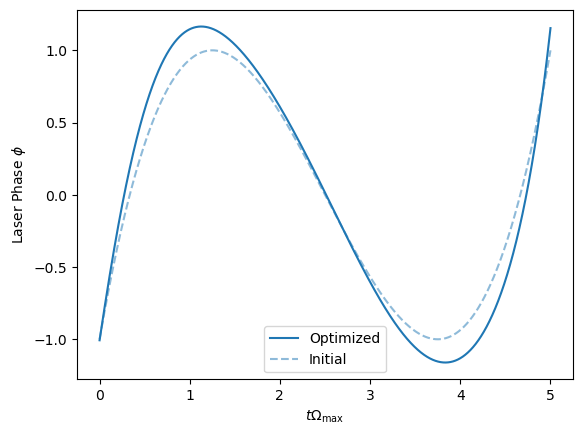

In [25]:
# plot (chebyshev) gate

iter_num = 20

print(gate_times[iter_num])

ts = np.linspace(0, gate_times[iter_num], 10001)
plt.xlabel("$t\\Omega_{\\text{max}}$")
plt.ylabel("Laser Phase $\\phi$")
plt.plot(ts, chebyshev.chebval((2/gate_times[iter_num])*ts-1, goat_results[iter_num].x[:-1]), color="tab:blue", label="Optimized")
plt.plot(ts, chebyshev.chebval((2/gate_times[iter_num])*ts-1, alpha0), linestyle="--", alpha=0.5, label="Initial")
plt.legend()

plt.show()

In [9]:
# test results using QuTiP simulations
simulated_fidelities = np.zeros(n_times)

for i in range(n_times):
    chebyshev_drive_strength_func = lambda t: 1
    chebyshev_phase_func = lambda t: chebyshev.chebval((2/gate_times[i])*t-1, goat_results[i].x[:-1])

    results = simulate_gate(chebyshev_drive_strength_func, chebyshev_phase_func, 100, 0, t_min, gate_times[i], 1001, plot=False)
    simulated_fidelities[i] = calculate_fidelity(results, single_qubit_phase=goat_results[i].x[-1])

    print(f"Gate Time: {gate_times[i]}, Fidelity: {simulated_fidelities[i]}")

/opt/miniconda3/envs/miscenv/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/opt/miniconda3/envs/miscenv/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Gate Time: 1.0, Fidelity: 0.36193647812932533
Gate Time: 1.2, Fidelity: 0.39999910140968775
Gate Time: 1.4, Fidelity: 0.3713810683128791
Gate Time: 1.6, Fidelity: 0.4527682177406021
Gate Time: 1.8, Fidelity: 0.410703051728805
Gate Time: 2.0, Fidelity: 0.4019419458819409
Gate Time: 2.2, Fidelity: 0.4016267501557246
Gate Time: 2.4000000000000004, Fidelity: 0.3363716957394173
Gate Time: 2.6, Fidelity: 0.3552423648585328
Gate Time: 2.8, Fidelity: 0.3360944472566028
Gate Time: 3.0, Fidelity: 0.3337327955715784
Gate Time: 3.2, Fidelity: 0.30083399911674324
Gate Time: 3.4000000000000004, Fidelity: 0.313113833542851
Gate Time: 3.6, Fidelity: 0.2364058533315948
Gate Time: 3.8000000000000003, Fidelity: 0.31880922699524145
Gate Time: 4.0, Fidelity: 0.29362800178959186
Gate Time: 4.2, Fidelity: 0.24897145194614426
Gate Time: 4.4, Fidelity: 0.22718913843144742
Gate Time: 4.6, Fidelity: 0.2476221465315983
Gate Time: 4.800000000000001, Fidelity: 0.22930844931216
Gate Time: 5.0, Fidelity: 0.4021810494

Text(0, 0.5, 'Simulated 1-F')

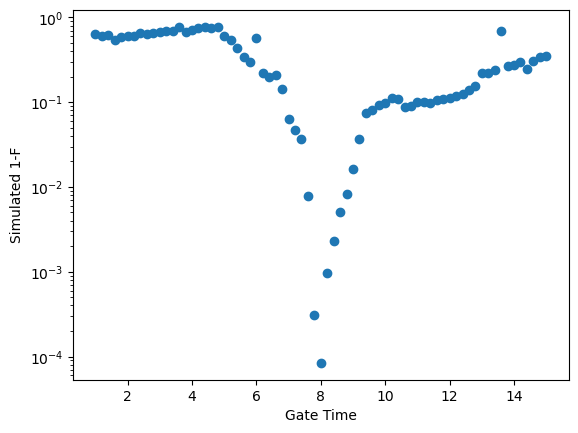

In [10]:
# plot simulated fidelities
plt.semilogy(gate_times, 1 - simulated_fidelities, linestyle="", marker="o")
plt.xlabel("Gate Time")
plt.ylabel("Simulated 1-F")

## Sweeping Number of Parameters

In [48]:
n_cheb_polys = np.arange(4, 81, 2)
n_iters = n_cheb_polys.size
goat_results = []
fidelities = np.zeros(n_iters)

control_funcs = [chebyshev_control_func_plus, chebyshev_control_func_minus]
control_param_derivs = chebyshev_control_param_derivs

t_min = 0
t_max = 7.612 # from TO gates paper 
t_span = [t_min, t_max]

control_extra_params = {
    "Omega_max": 1,
    "t_max": t_max
    # "n_pieces": n_pieces
}

optimizer_opts = {"maxiter": 400, "disp": False, "ftol": 1e-15, "gtol": 1e-15} # for L-BFGS-B

for i in range(n_iters):
    print(f"Number of Coefficients: {n_cheb_polys[i]}")
    alpha0 = np.zeros(n_cheb_polys[i] + 1)
    alpha0[3] = 1

    res = run_goat_optimization(
        H0,
        H_controls,
        control_funcs,
        control_param_derivs,
        alpha0,
        U_target,
        t_span,
        U_truncator,
        fidelity_func_name="GOAT",
        # alpha_bounds=alpha_bounds,
        constraints=chebyshev_constraint,
        single_qubit_phase_weights=[1, 2],
        control_extra_params=control_extra_params,
        optimizer_opts=optimizer_opts,
        callback=callback
    )

    goat_results.append(res)
    fidelities[i] = res.fun

Number of Coefficients: 4
Number of Coefficients: 6
Number of Coefficients: 8
Number of Coefficients: 10
Number of Coefficients: 12
Number of Coefficients: 14
Number of Coefficients: 16
Number of Coefficients: 18
Number of Coefficients: 20
Number of Coefficients: 22
Number of Coefficients: 24
Number of Coefficients: 26
Number of Coefficients: 28
Number of Coefficients: 30
Number of Coefficients: 32
Number of Coefficients: 34
Number of Coefficients: 36
Number of Coefficients: 38
Number of Coefficients: 40
Number of Coefficients: 42
Number of Coefficients: 44
Number of Coefficients: 46
Number of Coefficients: 48
Number of Coefficients: 50
Number of Coefficients: 52
Number of Coefficients: 54
Number of Coefficients: 56
Number of Coefficients: 58
Number of Coefficients: 60
Number of Coefficients: 62
Number of Coefficients: 64
Number of Coefficients: 66
Number of Coefficients: 68
Number of Coefficients: 70
Number of Coefficients: 72
Number of Coefficients: 74
Number of Coefficients: 76
Numb

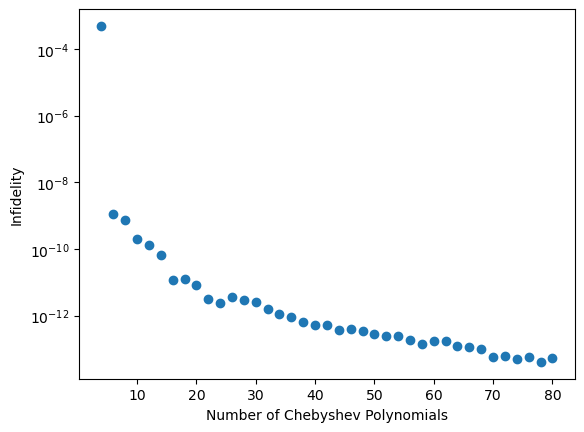

In [49]:
plt.semilogy(n_cheb_polys, fidelities, linestyle="", marker="o")
plt.xlabel("Number of Chebyshev Polynomials")
plt.ylabel("Infidelity")
plt.show()

50


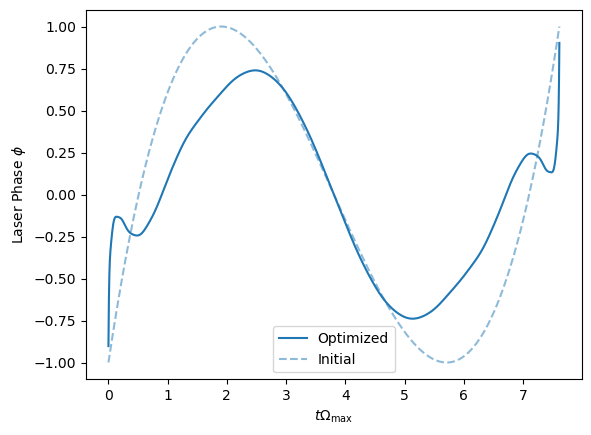

In [34]:
# plot (chebyshev) gate

iter_num = -1

print(n_cheb_polys[iter_num])

ts = np.linspace(0, t_max, 10001)
plt.xlabel("$t\\Omega_{\\text{max}}$")
plt.ylabel("Laser Phase $\\phi$")
plt.plot(ts, chebyshev.chebval((2/t_max)*ts-1, goat_results[iter_num].x[:-1]), color="tab:blue", label="Optimized")
plt.plot(ts, chebyshev.chebval((2/t_max)*ts-1, alpha0), linestyle="--", alpha=0.5, label="Initial")
plt.legend()

plt.show()

In [50]:
# test results using QuTiP simulations
simulated_fidelities = np.zeros(n_iters)

for i in range(n_iters):
    chebyshev_drive_strength_func = lambda t: 1
    chebyshev_phase_func = lambda t: chebyshev.chebval((2/t_max)*t-1, goat_results[i].x[:-1])

    results = simulate_gate(chebyshev_drive_strength_func, chebyshev_phase_func, 100, 0, t_min, t_max, 1001, plot=False)
    simulated_fidelities[i] = calculate_fidelity(results, single_qubit_phase=goat_results[i].x[-1])

    print(f"Number of Chebyshev Coefficients: {n_cheb_polys[i]}, Fidelity: {simulated_fidelities[i]}")

Number of Chebyshev Coefficients: 4, Fidelity: 0.7166987403650182
Number of Chebyshev Coefficients: 6, Fidelity: 0.995398725528855
Number of Chebyshev Coefficients: 8, Fidelity: 0.9999363093517175
Number of Chebyshev Coefficients: 10, Fidelity: 0.999797588397679
Number of Chebyshev Coefficients: 12, Fidelity: 0.9993123333806244
Number of Chebyshev Coefficients: 14, Fidelity: 0.9994805398583839
Number of Chebyshev Coefficients: 16, Fidelity: 0.9994847766509105
Number of Chebyshev Coefficients: 18, Fidelity: 0.9994922595342195
Number of Chebyshev Coefficients: 20, Fidelity: 0.9994861911794019
Number of Chebyshev Coefficients: 22, Fidelity: 0.9994942274686398
Number of Chebyshev Coefficients: 24, Fidelity: 0.9995013023034224
Number of Chebyshev Coefficients: 26, Fidelity: 0.9995086327428316
Number of Chebyshev Coefficients: 28, Fidelity: 0.9995114251889032
Number of Chebyshev Coefficients: 30, Fidelity: 0.999512611003579
Number of Chebyshev Coefficients: 32, Fidelity: 0.9995134201600617
N

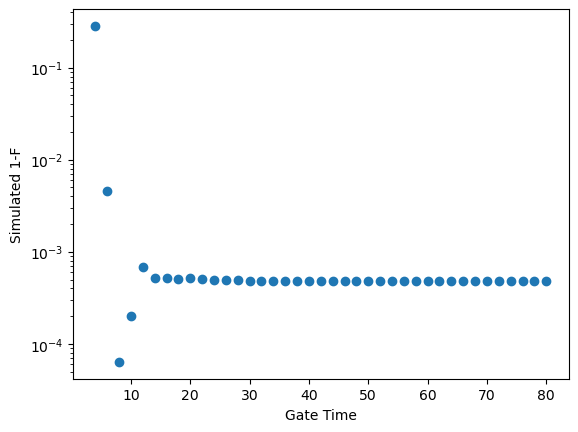

In [51]:
# plot simulated fidelities
plt.semilogy(n_cheb_polys, 1 - simulated_fidelities, linestyle="", marker="o")
plt.xlabel("Gate Time")
plt.ylabel("Simulated 1-F")
plt.show()

## Save Results

In [11]:
# save results
import pickle

# with open("results/goat_run_18.pkl", "wb") as f:
#     pickle.dump((res, prev_params), f)

with open("results/time_sweep_5.pkl", "wb") as f:
    pickle.dump((gate_times, goat_results, fidelities), f)

In [ ]:
# exporting to pulse format for qutip simulations
with open("results/goat_run_13.pkl", "rb") as file:
    (loaded_res, loaded_prev_params) = pickle.load(file)

times = np.linspace(0, t_max, n_pieces)
phases = loaded_res.x[:-1]
Omegas = control_extra_params["Omega_max"] * np.ones(n_pieces)


np.savetxt("pulses/goat_gate4_best.csv", np.column_stack((times, Omegas, phases)), delimiter=",", header="t,|Omega|,arg(Omega)")